In [1]:
from lib import geoSearch
import json, logging
GS = geoSearch.GeoSearch("elasticsearch-geo",9200)
from shapely.geometry import mapping, shape
geoSearch.logger.setLevel(logging.INFO)

/usr/local/lib/python2.7/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.25.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix as cm
%matplotlib inline  

test_set = pd.read_csv('exactTestDataset.csv', index_col=0, encoding='utf-8')

In [3]:
test_set.head()

,ubicacion,alternativa,texto,matchType
0,mercedes#tacuarembo,mercedes#tacuarembo,hola imtransito semaforo esquina tacuarembo es...,cruces_vias
1,dr-emilio-frugoni#chana,dr-emilio-frugoni#chana,imtransito comomemuevouy mvdtransporte chana e...,cruces_vias
2,palacio-legislativo-edificio-anexo&palacio-leg...,palacio-legislativo-edificio-anexo&palacio-leg...,montevideo ahora choque esquina palacio legisl...,geonames
3,santa-cruz-de-la-sierra#vizcaya,santa-cruz-de-la-sierra#vizcaya,sharito17849631 mvddecide belvederegatos munic...,cruces_vias
4,arenal-grande#colonia,arenal-grande#colonia,hecho historico medicina mundial ciudad montev...,cruces_vias


In [4]:
score_limit = 0

In [5]:
test_set_run = GS.test_kit('exactTestDataset.csv', score_limit)

/home/user/.local/lib/python2.7/site-packages/unidecode/__init__.py:46: RuntimeWarning: Argument <type 'str'> is not an unicode object. Passing an encoded string will likely have unexpected results.
  _warn_if_not_unicode(string)


In [6]:
test_set_run.head()

,ubicacion,alternativa,texto,matchType,ubicacionEncontrada,scoreMejorMatch,tipoUbicacionEncontrada,time_ms
0,mercedes#tacuarembo,mercedes#tacuarembo,hola imtransito semaforo esquina tacuarembo es...,cruces_vias,mercedes#tacuarembo,319055.469818,cruces_vias,51.424
1,dr-emilio-frugoni#chana,dr-emilio-frugoni#chana,imtransito comomemuevouy mvdtransporte chana e...,cruces_vias,dr-emilio-frugoni#chana,50818.370978,cruces_vias,21.695
2,palacio-legislativo-edificio-anexo&palacio-leg...,palacio-legislativo-edificio-anexo&palacio-leg...,montevideo ahora choque esquina palacio legisl...,geonames,palacio-legislativo-edificio-anexo&palacio-leg...,1420.020446,geonames,27.550
3,santa-cruz-de-la-sierra#vizcaya,santa-cruz-de-la-sierra#vizcaya,sharito17849631 mvddecide belvederegatos munic...,cruces_vias,santa-cruz-de-la-sierra#vizcaya,521006.657877,cruces_vias,69.156
4,arenal-grande#colonia,arenal-grande#colonia,hecho historico medicina mundial ciudad montev...,cruces_vias,arenal-grande#colonia,231109.028718,cruces_vias,53.656


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f59b5218650>]], dtype=object)

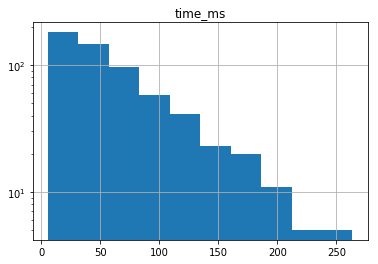

In [7]:
test_set_run.hist(column='time_ms', log=True)

In [8]:
test_set_run['truthLocation'] = np.where(test_set_run['ubicacion'] != '-', True, False)
test_set_run['truthTypeLocation'] = np.where(test_set_run['matchType'] != '-', True, False)

In [32]:
def getFoundLocation(row):
    """
    Tiene ubicacion y encontre ubicacion correcta => True
    Tiene ubicacion y no encontré o encontré mal => False
    No tiene ubicacion y encontré algo => True
    No tiene ubicación y no encontré => False
    """
    if row['ubicacion'] != '-' and row['ubicacionEncontrada'] in [row['ubicacion'], row['alternativa']]:
        return True
    elif row['ubicacion'] != '-':
        return False
    elif row['ubicacionEncontrada'] != '-':
        return True
    else: 
        return False

In [33]:
test_set_run['foundExactLocation'] = test_set_run.apply(lambda row: getFoundLocation(row),axis=1)
test_set_run['foundLocationType'] = np.where(
    (test_set_run['matchType'] == test_set_run['tipoUbicacionEncontrada']),True, False)

In [34]:
cm(test_set_run['truthLocation'], test_set_run['foundExactLocation'])

array([[178, 287],
       [ 12, 110]])

In [35]:
cm(test_set_run['truthTypeLocation'], test_set_run['foundLocationType'])

array([[288, 178],
       [  1, 120]])

In [36]:
test_set_run.to_csv('exactTestDatasetResult-Limit:{}.csv'.format(score_limit))